This is the explanation of machine learning basics from from ch5 of deep learning with pytorch book.


In [1]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

### data

Here, the t_c values are temperatures in Celsius, and the t_u values are our unknown
units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. 

In [2]:

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

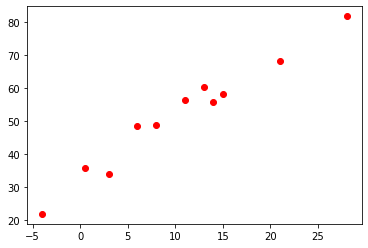

In [3]:
import matplotlib.pyplot as plt

plt.plot(t_c, t_u, 'ro')
plt.show()

### simplest model

We have a model with some unknown parameters, and we
need to estimate those parameters so that the error between predicted outputs and
measured values is as low as possible. We notice that we still need to exactly define a
measure of the error. Such a measure, which we refer to as the loss function, should be
high if the error is high and should ideally be as low as possible for a perfect match.
Our optimization process should therefore aim at finding w and b so that the loss
function is at a minimum. 

We’ve already created our data tensors, so now let’s write out the model as a
Python function:

In [4]:
def model(t_u, w, b):
    return w * t_u + b

### loss function

A loss function (or cost function) is a function that computes a single numerical value
that the learning process will attempt to minimize. The calculation of loss typically
involves taking the difference between the desired outputs for some training samples
and the outputs actually produced by the model when fed those samples. In our case,
that would be the difference between the predicted temperatures t_p output by our
model and the actual measurements: t_p – t_c.
 We need to make sure the loss function makes the loss positive both when t_p is
greater than and when it is less than the true t_c, since the goal is for t_p to match t_c.
We have a few choices, the most straightforward being |t_p – t_c| and (t_p – t_c)^2.
Based on the mathematical expression we choose, we can emphasize or discount certain
errors. Conceptually, a loss function is a way of prioritizing which errors to fix from our
training samples, so that our parameter updates result in adjustments to the outputs for
the highly weighted samples instead of changes to some other samples’ output that had
a smaller loss.

Note that we are building a tensor of differences, taking their square element-wise,
and finally producing a scalar loss function by averaging all of the elements in the
resulting tensor. It is a mean square loss.

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

### model in practice

 We can now initialize the parameters, invoke the model,

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

### Broadcasting in pytorch

result of using vector multiplication

In [8]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)

print("x : ", x.shape,"y : ", y.shape)
print("z : ", z.shape,"a : ", a.shape)

print("x * y : ", (x * y).shape)
print("y * z : ",(y * z).shape)
print("y * z * a : ", (y * z * a).shape)

x :  torch.Size([]) y :  torch.Size([3, 1])
z :  torch.Size([1, 3]) a :  torch.Size([2, 1, 1])
x * y :  torch.Size([3, 1])
y * z :  torch.Size([3, 3])
y * z * a :  torch.Size([2, 3, 3])


### updating values based on loss

Gradient descent is not that different from the scenario we just described. The idea is
to compute the rate of change of the loss with respect to each parameter, and modify
each parameter in the direction of decreasing loss. Just like when we were fiddling
with the knobs, we can estimate the rate of change by adding a small number to w and
b and seeing how much the loss changes in that neighborhood:

In [9]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
    loss_fn(model(t_u,w-delta, b), t_c)) / (2.0 * delta)

This is saying that in the neighborhood of the current values of w and b, a unit
increase in w leads to some change in the loss. If the change is negative, then we need
to increase w to minimize the loss, whereas if the change is positive, we need to
decrease w. By how much? Applying a change to w that is proportional to the rate of
change of the loss is a good idea, especially when the loss has several parameters: we
apply a change to those that exert a significant change on the loss. It is also wise to
change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current w value. Therefore,
we typically should scale the rate of change by a small factor. This scaling factor has
many names; the one we use in machine learning is learning_rate:


In [10]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [11]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c)-
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b- learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent. By reiterating
these evaluations (and provided we choose a small enough learning rate), we will
converge to an optimal value of the parameters for which the loss computed on the
given data is minimal

### creating functions out of this

In [12]:
# derivative of loss 
def dloss_fn(t_p, t_c):
    # same as
    # sqared_diffs = (t_p - t_c)**2
    # return squred_diffs.mean()
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [13]:
# derivative of model w.r.t w
def dmodel_dw(t_u, w, b):
    return t_u

In [14]:
# derivativ of model w.r.t b
def dmodel_db(t_u, w, b):
    return 1.0

### Defining the gradient function

Putting all of this together, the function returning the gradient of the loss with respect
to w and b is

In [15]:
# chain rule in action
def grad_dn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [16]:
# how stack works
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
torch.stack([a,b])

tensor([[1, 2, 3],
        [4, 5, 6]])

### Training loop

We now have everything in place to optimize our parameters. Starting from a tentative
value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until w and b stop changing. There are several stopping criteria; for now,
we’ll stick to a fixed number of iterations.

Since we’re at it, let’s introduce another piece of terminology. We call a training iteration during which we update the parameters for all of our training samples an epoch

In [17]:
def training_loop(n_epochs, learning_rate,params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        w, b = params
        
        t_p = model(t_u, w,b)
        loss = loss_fn(t_p, t_c)
        grad = grad_dn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        print("Epoch : ", epoch, " loss : ", loss)
    return params

In [18]:
training_loop(n_epochs = 100, learning_rate=1e-2, params= torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epoch :  1  loss :  tensor(1763.8848)
Epoch :  2  loss :  tensor(5802484.5000)
Epoch :  3  loss :  tensor(1.9408e+10)
Epoch :  4  loss :  tensor(6.4916e+13)
Epoch :  5  loss :  tensor(2.1713e+17)
Epoch :  6  loss :  tensor(7.2626e+20)
Epoch :  7  loss :  tensor(2.4292e+24)
Epoch :  8  loss :  tensor(8.1251e+27)
Epoch :  9  loss :  tensor(2.7177e+31)
Epoch :  10  loss :  tensor(9.0901e+34)
Epoch :  11  loss :  tensor(inf)
Epoch :  12  loss :  tensor(inf)
Epoch :  13  loss :  tensor(inf)
Epoch :  14  loss :  tensor(inf)
Epoch :  15  loss :  tensor(inf)
Epoch :  16  loss :  tensor(inf)
Epoch :  17  loss :  tensor(inf)
Epoch :  18  loss :  tensor(inf)
Epoch :  19  loss :  tensor(inf)
Epoch :  20  loss :  tensor(inf)
Epoch :  21  loss :  tensor(inf)
Epoch :  22  loss :  tensor(inf)
Epoch :  23  loss :  tensor(nan)
Epoch :  24  loss :  tensor(nan)
Epoch :  25  loss :  tensor(nan)
Epoch :  26  loss :  tensor(nan)
Epoch :  27  loss :  tensor(nan)
Epoch :  28  loss :  tensor(nan)
Epoch :  29  l

tensor([nan, nan])

so its not really working. Lets improve our training loop.

In [19]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_dn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        if epoch in {1,2,3,10,11,99,100,4000,5000}:
            print('Epoch loss :', epoch, " loss ", float(loss))
            if print_params:
                print('  params: ', params)
                print('  grad: ', grad)
        
        if epoch in {4, 12, 101}:
            print('...')
        
        if not torch.isfinite(loss).all():
            break
    return params

In [20]:
training_loop(n_epochs = 100, learning_rate=1e-2, params= torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epoch loss : 1  loss  1763.884765625
  params:  tensor([-44.1730,  -0.8260])
  grad:  tensor([4517.2964,   82.6000])
Epoch loss : 2  loss  5802484.5
  params:  tensor([2568.4011,   45.1637])
  grad:  tensor([-261257.4062,   -4598.9702])
Epoch loss : 3  loss  19408029696.0
  params:  tensor([-148527.7344,   -2616.3931])
  grad:  tensor([15109614.0000,   266155.6875])
...
Epoch loss : 10  loss  9.090110518901907e+34
  params:  tensor([3.2144e+17, 5.6621e+15])
  grad:  tensor([-3.2700e+19, -5.7600e+17])
Epoch loss : 11  loss  inf
  params:  tensor([-1.8590e+19, -3.2746e+17])
  grad:  tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

### Overtraining

Wait, what happened? Our training process literally blew up, leading to losses becoming inf. This is a clear sign that params is receiving updates that are too large, and
their values start oscillating back and forth as each update overshoots and the next
overcorrects even more. The optimization process is unstable: it diverges instead of
converging to a minimum.


How can we limit the magnitude of learning_rate * grad? Well, that looks easy. We
could simply choose a smaller learning_rate, and indeed, the learning rate is one of
the things we typically change when training does not go as well as we would like.8
 We
usually change learning rates by orders of magnitude, so we might try with 1e-3 or
1e-4, which would decrease the magnitude of the updates by orders of magnitude.
Let’s go with 1e-4 and see how it works out:

In [21]:
training_loop(n_epochs = 100, learning_rate=1e-4, params= torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epoch loss : 1  loss  1763.884765625
  params:  tensor([ 0.5483, -0.0083])
  grad:  tensor([4517.2964,   82.6000])
Epoch loss : 2  loss  323.09051513671875
  params:  tensor([ 0.3623, -0.0118])
  grad:  tensor([1859.5493,   35.7843])
Epoch loss : 3  loss  78.92963409423828
  params:  tensor([ 0.2858, -0.0135])
  grad:  tensor([765.4666,  16.5122])
...
Epoch loss : 10  loss  29.105247497558594
  params:  tensor([ 0.2324, -0.0166])
  grad:  tensor([1.4803, 3.0544])
Epoch loss : 11  loss  29.104167938232422
  params:  tensor([ 0.2323, -0.0169])
  grad:  tensor([0.5781, 3.0384])
...
Epoch loss : 99  loss  29.023582458496094
  params:  tensor([ 0.2327, -0.0435])
  grad:  tensor([-0.0533,  3.0226])
Epoch loss : 100  loss  29.022666931152344
  params:  tensor([ 0.2327, -0.0438])
  grad:  tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

Nice—the behavior is now stable. But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could
obviate this issue by making learning_rate adaptive: that is, change according to the
magnitude of updates.

### Normalising inputs

We can see that the first-epoch gradient for the weight is about 50 times larger than
the gradient for the bias. This means the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update
one will be so large as to be unstable for the other; and a rate that’s appropriate for
the other won’t be large enough to meaningfully change the first. That means we’re
not going to be able to update our parameters unless we change something about our
formulation of the problem

 There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get
too far from the range of –1.0 to 1.0, roughly speaking. In our case, we can achieve
something close enough to that by simply multiplying t_u by 0.1:


In [22]:
t_un = 0.1 * t_u

Here, we denote the normalized version of t_u by appending an n to the variable
name. At this point, we can run the training loop on our normalized input:

In [23]:
training_loop(
    n_epochs=100, 
    learning_rate=1e-2, 
    params= torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch loss : 1  loss  80.36434173583984
  params:  tensor([1.7761, 0.1064])
  grad:  tensor([-77.6140, -10.6400])
Epoch loss : 2  loss  37.574913024902344
  params:  tensor([2.0848, 0.1303])
  grad:  tensor([-30.8623,  -2.3864])
Epoch loss : 3  loss  30.871076583862305
  params:  tensor([2.2094, 0.1217])
  grad:  tensor([-12.4631,   0.8587])
...
Epoch loss : 10  loss  29.030488967895508
  params:  tensor([ 2.3232, -0.0710])
  grad:  tensor([-0.5355,  2.9295])
Epoch loss : 11  loss  28.941877365112305
  params:  tensor([ 2.3284, -0.1003])
  grad:  tensor([-0.5240,  2.9264])
...
Epoch loss : 99  loss  22.21418571472168
  params:  tensor([ 2.7508, -2.4910])
  grad:  tensor([-0.4453,  2.5208])
Epoch loss : 100  loss  22.148710250854492
  params:  tensor([ 2.7553, -2.5162])
  grad:  tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to 1e-2, parameters don’t blow up during
iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so
using a single learning_rate for both parameters works just fine. We could probably
do a better job of normalization than a simple rescaling by a factor of 10, but since
doing so is good enough for our needs, we’re going to stick with that for now.

running for 5000 epochs:

In [24]:
new_params = training_loop(
    n_epochs=5000, 
    learning_rate=1e-2, 
    params= torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch loss : 1  loss  80.36434173583984
  params:  tensor([1.7761, 0.1064])
  grad:  tensor([-77.6140, -10.6400])
Epoch loss : 2  loss  37.574913024902344
  params:  tensor([2.0848, 0.1303])
  grad:  tensor([-30.8623,  -2.3864])
Epoch loss : 3  loss  30.871076583862305
  params:  tensor([2.2094, 0.1217])
  grad:  tensor([-12.4631,   0.8587])
...
Epoch loss : 10  loss  29.030488967895508
  params:  tensor([ 2.3232, -0.0710])
  grad:  tensor([-0.5355,  2.9295])
Epoch loss : 11  loss  28.941877365112305
  params:  tensor([ 2.3284, -0.1003])
  grad:  tensor([-0.5240,  2.9264])
...
Epoch loss : 99  loss  22.21418571472168
  params:  tensor([ 2.7508, -2.4910])
  grad:  tensor([-0.4453,  2.5208])
Epoch loss : 100  loss  22.148710250854492
  params:  tensor([ 2.7553, -2.5162])
  grad:  tensor([-0.4446,  2.5165])
...
Epoch loss : 4000  loss  2.927680253982544
  params:  tensor([  5.3643, -17.2853])
  grad:  tensor([-0.0006,  0.0033])
Epoch loss : 5000  loss  2.927647590637207
  params:  tensor(

our loss decreases while we change parameters along the direction of gradient
descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to
converge to zero, or that the data points don’t sit exactly on a line.

measurements were not perfectly accurate, or there was noise involved in the reading.
 But look: the values for w and b look an awful lot like the numbers we need to use
to convert Celsius to Fahrenheit (after accounting for our earlier normalization when
we multiplied our inputs by 0.1). The exact values would be w=5.5556 and b=-
17.7778. Our fancy thermometer was showing temperatures in Fahrenheit the whole time

### visualizing

Let’s revisit something we did right at the start: plotting our data. Seriously, this is the
first thing anyone doing data science should do. Always plot the heck out of the data:

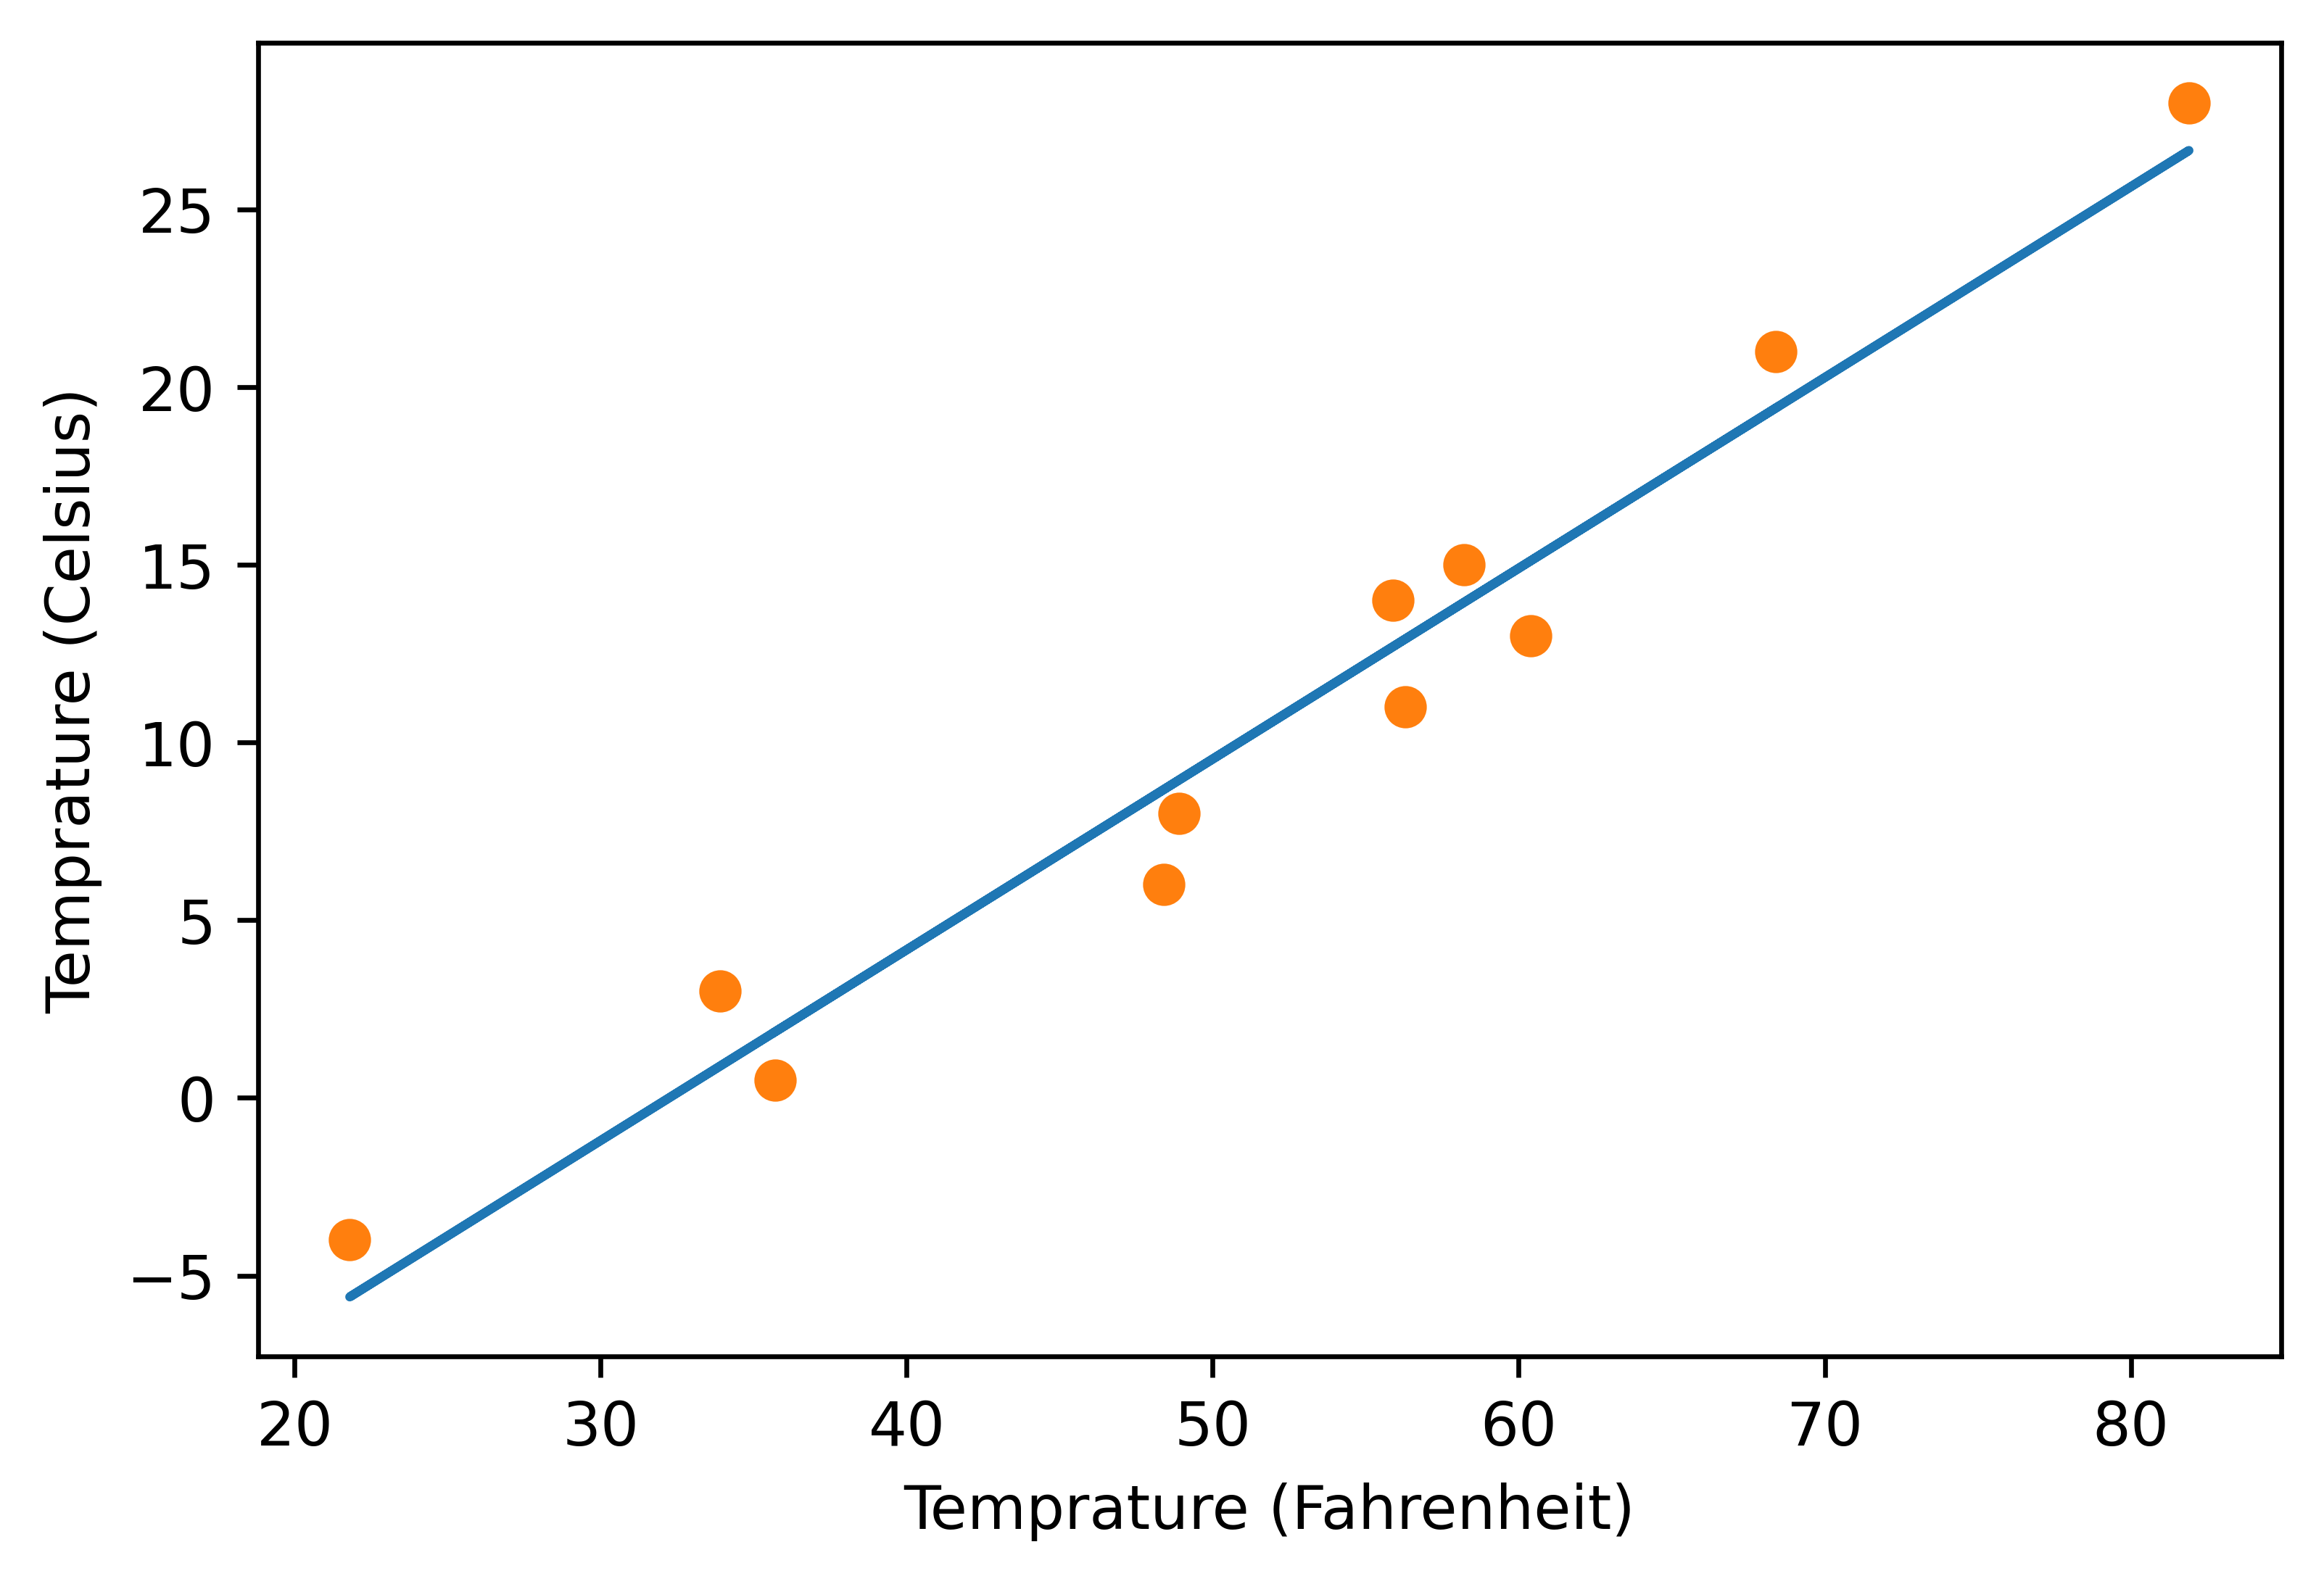

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, new_params[0], new_params[1])

fig = plt.figure(dpi=600)
plt.xlabel("Temprature (Fahrenheit)")
plt.ylabel("Temprature (Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(),t_c.numpy(), 'o')

### Using the autograd in pytorch

Lets try wonderful feature called autograd in pytorch!

PyTorch tensors can remember where they come from, in terms of the operations and
parent tensors that originated them, and they can automatically provide the chain of
derivatives of such operations with respect to their inputs. This means we won’t need
to derive our model by hand;10 given a forward expression, no matter how nested,
PyTorch will automatically provide the gradient of that expression with respect to its
input parameters.

In [26]:
# we have our model and loss function above
# lets initialise the params

params = torch.tensor([1.0,0.0], requires_grad= True)

Notice the requires_grad=True argument to the tensor constructor? That argument
is telling PyTorch to track the entire family tree of tensors resulting from operations
on params. In other words, any tensor that will have params as an ancestor will have
access to the chain of functions that were called to get from params to that tensor. In
case these functions are differentiable (and most PyTorch tensor operations will be),
the value of the derivative will be automatically populated as a grad attribute of the
params tensor.
 In general, all PyTorch tensors have an attribute named grad. Normally, it’s None:

In [27]:
params.grad is None

True

All we have to do to populate it is to start with a tensor with requires_grad set to
True, then call the model and compute the loss, and then call backward on the loss
tensor:

In [28]:
loss = loss_fn(model(t_u, *params), t_c) 
# equivalent to loss = loss_fun(model(t_u, params[0], params[1]), t_c)

loss.backward() 

In [29]:
# params got updated!
params.grad

tensor([4517.2969,   82.6000])

At this point, the grad attribute of params contains the derivatives of the loss with
respect to each element of params.
 When we compute our loss while the parameters w and b require gradients, in
addition to performing the actual computation, PyTorch creates the autograd graph
with the operations (in black circles) as nodes, as shown in the top row of figure 5.10. When we call loss.backward(), PyTorch traverses this graph in the reverse
direction to compute the gradients, 

We could have any number of tensors with requires_grad set to True and any composition of functions. In this case, PyTorch would compute the derivatives of the loss
throughout the chain of functions (the computation graph) and accumulate their values in the grad attribute of those tensors (the leaf nodes of the graph).

 Alert! Big gotcha ahead. This is something PyTorch newcomers—and a lot of more
experienced folks, too—trip up on regularly. We just wrote accumulate, not store.
WARNING Calling backward will lead derivatives to accumulate at leaf nodes.
We need to zero the gradient explicitly after using it for parameter updates.

In [30]:
# setting params to zero
if params.grad is not None:
    params.grad.zero_()

### Autograd enabled training loop

In [31]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs +1):
        
        # this should be done prior to calling backward
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print('Epoch ', epoch, ' loss ', float(loss))
            
    return params

Note that our code updating params is not quite as straightforward as we might have
expected. There are two particularities. 

First, we are encapsulating the update in a
no_grad context using the Python with statement. This means within the with block,
the PyTorch autograd mechanism should look away:
11 that is, not add edges to the forward graph. In fact, when we are executing this bit of code, the forward graph that
PyTorch records is consumed when we call backward, leaving us with the params leaf
node. But now we want to change this leaf node before we start building a fresh forward graph on top of it

 Second, we update params in place. This means we keep the same params tensor
around but subtract our update from it. When using autograd, we usually avoid inplace updates because PyTorch’s autograd engine might need the values we would be
modifying for the backward pass. Here, however, we are operating without autograd,
and it is beneficial to keep the params tensor

In [32]:
training_loop(
    n_epochs =5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c
)

Epoch  500  loss  7.860115051269531
Epoch  1000  loss  3.828537940979004
Epoch  1500  loss  3.092191219329834
Epoch  2000  loss  2.957697868347168
Epoch  2500  loss  2.933133840560913
Epoch  3000  loss  2.9286484718322754
Epoch  3500  loss  2.9278297424316406
Epoch  4000  loss  2.9276793003082275
Epoch  4500  loss  2.927651882171631
Epoch  5000  loss  2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

Yay ! result as the previous one. Lets look at optimisers next.

### optimisers 

In the example code, we used vanilla gradient descent for optimization, which worked
fine for our simple case. Needless to say, there are several optimization strategies and
tricks that can assist convergence, especially when models get complicated.

PyTorch abstracts the optimization strategy away from user code:
that is, the training loop we’ve examined. This saves us from the boilerplate busywork
of having to update each and every parameter to our model ourselves. The torch
module has an optim submodule where we can find classes implementing different
optimization algorithms

In [33]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically
with requires_grad set to True) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their grad attribute

Each optimizer exposes two methods: zero_grad and step. zero_grad zeroes the
grad attribute of all the parameters passed to the optimizer upon construction. step
updates the value of those parameters according to the optimization strategy implemented by the specific optimizer

### Using gradient descent optimiser

In [34]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params],lr=learning_rate)

Here SGD stands for stochastic gradient descent. Actually, the optimizer itself is exactly a
vanilla gradient descent (as long as the momentum argument is set to 0.0, which is the
default). The term stochastic comes from the fact that the gradient is typically obtained
by averaging over a random subset of all input samples, called a minibatch. However, the
optimizer does not know if the loss was evaluated on all the samples (vanilla) or a random subset of them (stochastic), so the algorithm is literally the same in the two cases.

In [35]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

In [36]:
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of params is updated upon calling step without us having to touch it ourselves! What happens is that the optimizer looks into params.grad and updates
params, subtracting learning_rate times grad from it, exactly as in our former handrolled code.
 Ready to stick this code in a training loop? Nope! The big gotcha almost got us—
we forgot to zero out the gradients. Had we called the previous code in a loop, gradients would have accumulated in the leaves at every call to backward, and our gradient
descent would have been all over the place! Here’s the loop-ready code, with the extra
zero_grad at the correct spot (right before the call to backward):

In [37]:
params =torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [38]:
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

In [40]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [41]:
params

tensor([1.7761, 0.1064], requires_grad=True)

In [42]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1,n_epochs+1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%500 == 0:
            print(epoch, float(loss))
    
    return params

In [43]:
params = torch.tensor([1.0,0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    t_u=t_un,
    t_c=t_c
)

500 7.860119819641113
1000 3.828537940979004
1500 3.092191219329834
2000 2.957697868347168
2500 2.933133840560913
3000 2.9286484718322754
3500 2.9278297424316406
4000 2.9276793003082275
4500 2.927651882171631
5000 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

### trying other optimizers

In [44]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer=optim.Adam([params], lr=learning_rate)

In [45]:
training_loop(
    n_epochs=2000,
    optimizer=optimizer,
    params=params,
    t_u=t_u,
    t_c=t_c
)

500 7.612900257110596
1000 3.086700439453125
1500 2.928579092025757
2000 2.9276442527770996


tensor([  0.5367, -17.3021], requires_grad=True)

The optimizer is not the only flexible part of our training loop. Let’s turn our attention to the model. In order to train a neural network on the same data and the same
loss, all we would need to change is the model function. It wouldn’t make particular
sense in this case, since we know that converting Celsius to Fahrenheit amounts to a
linear transformation, but we’ll do it anyway in chapter 6. We’ll see quite soon that
neural networks allow us to remove our arbitrary assumptions about the shape of the
function we should be approximating. Even so, we’ll see how neural networks manage
to be trained even when the underlying processes are highly nonlinear

### splitting a dataset

In [46]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

In [48]:
shuffled_indices = torch.randperm(n_samples)

In [49]:
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

In [50]:
train_indices, val_indices

(tensor([ 1,  4,  2,  6,  9,  5, 10,  0,  7]), tensor([8, 3]))

In [51]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

In [52]:
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [54]:
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [62]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <=3 or epoch %500 == 0:
            print(epoch, train_loss.item(), val_loss.item())
    return params
        

From the previous training loop, we can appreciate that we only ever call backward on
train_loss. Therefore, errors will only ever backpropagate based on the training
set—the validation set is used to provide an independent evaluation of the accuracy of
the model’s output on data that wasn’t used for training.

In [60]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer= optim.SGD([params], lr=learning_rate)

In [63]:
training_loop(
n_epochs = 3000,
optimizer = optimizer,
params = params,
train_t_u = train_t_un,
val_t_u = val_t_un,
train_t_c = train_t_c,
val_t_c = val_t_c)

1 29.694875717163086 114.14714050292969
2 24.317277908325195 86.28421783447266
3 23.11189842224121 75.5647964477539
500 6.915389060974121 24.981304168701172
1000 3.4118995666503906 12.701473236083984
1500 2.648101806640625 8.67732048034668
2000 2.4815833568573 7.1710710525512695
2500 2.4452812671661377 6.549029350280762
3000 2.437368631362915 6.276299476623535


tensor([  5.0879, -15.7779], requires_grad=True)

Here we are not being entirely fair to our model. The validation set is really small, so
the validation loss will only be meaningful up to a point. In any case, we note that the
validation loss is higher than our training loss, although not by an order of magnitude

The only tensors these two graphs have in common are the parameters. When we call
backward on train_loss, we run backward on the first graph. In other words, we
accumulate the derivatives of train_loss with respect to the parameters based on the
computation generated from train_t_u.
 If we (incorrectly) called backward on val_loss as well, we would accumulate the
derivatives of val_loss with respect to the parameters on the same leaf nodes.

 In order to address this, PyTorch allows us to switch off autograd when we don’t
need it, using the torch.no_grad context manager.12 We won’t see any meaningful
advantage in terms of speed or memory consumption on our small problem. However, for larger models, the differences can add up. We can make sure this works by
checking the value of the requires_grad attribute on the val_loss tensor:

In [64]:
def training_loop(n_epocs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs+1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False 
            # checks that requires grad are forced false inside this block
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

Using the related set_grad_enabled context, we can also condition the code to run
with autograd enabled or disabled, according to a Boolean expression—typically indicating whether we are running in training or inference mode. We could, for instance,
define a calc_forward function that takes data as input and runs model and loss_fn
with or without autograd according to a Boolean train_is argument:

In [65]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss =  loss_fn(t_p,t_c)
    return loss

We started this chapter with a big question: how is it that a machine can learn from
examples? We spent the rest of the chapter describing the mechanism with which a
model can be optimized to fit data. We chose to stick with a simple model in order to
see all the moving parts without unneeded complications.